In this notebook we preprocess the flattened dataset used for the model prediction; we mainly perform check on the values nad improve formatting of certain columns.

For example, when a city has values "Olten" and "oltEN", we improve the formatting in order to have consistent naming.

### Libraries and dataset imports

In this section we import the required dataset and libraries.

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
df = pd.read_csv("../../../00-Project/datasets/flattened_dataset.csv")

/tmp/ipykernel_137243/837169441.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../../00-Project/datasets/flattened_dataset.csv")


In [82]:
df.columns

Index(['shipment_id', 'customer_price', 'expected_carrier_price',
       'final_carrier_price', 'weight', 'shipment_type', 'insurance_type',
       'customer_id', 'domain_name', 'booking_state', 'lms_plus', 'exworks_id',
       'margin', 'created_date_customer', 'domain_name_customer',
       'main_industry_name_customer', 'industry_sector_name_customer',
       'segmentation_customer', 'sequence_number_customer',
       'structure_number_customer', 'is_master_customer',
       'created_date_delivery', 'domain_name_delivery', 'postal_code_delivery',
       'city_delivery', 'name_country_delivery', 'iso_country_code_delivery',
       'continent_delivery', 'EU_delivery', 'created_date_pickup',
       'domain_name_pickup', 'postal_code_pickup', 'city_pickup',
       'name_country_pickup', 'iso_country_code_pickup', 'continent_pickup',
       'EU_pickup', 'created_date_service', 'name_service', 'service_type',
       'transport_type', 'domain_name_service', 'name_carrier',
       'created_

### Helpful functions created for use later

In this section we store the function which we are going to use several times to perform checks and corrections.

We use this function in order to analyze the missing values of a given column

In [83]:
def analyze_missing_values(df, column):
    """Analyze missing values in a column."""
    missing_count = df[column].isna().sum()
    total_records = len(df)
    missing_percentage = (missing_count / total_records) * 100
    
    print(f"Total missing values: {missing_count}")
    print(f"Missing percentage: {missing_percentage:.2f}%")


We use this function in order to analyze numeric columns for null values and decimal places

In [84]:
def analyze_numeric_values(df, column):
    """Analyze numeric column values and decimal places."""
    print(f"\n=== {column} ===")
    print(f"Data type: {df[column].dtype}")
    print(f"Null values: {df[column].isnull().sum()}")
    
    non_null_values = df[column].dropna()
    decimal_places = (non_null_values % 1).apply(lambda x: len(str(x).split('.')[-1]) if x > 0 else 0)
    print("\nDecimal places distribution:")
    print(decimal_places.value_counts().sort_index())
    
    print(f"\nNegative values: {(non_null_values < 0).sum()}")
    print(f"Zero values: {(non_null_values == 0).sum()}")
    print(f"Infinite values: {np.isinf(non_null_values).sum()}")


We use this function to check for inconsistencies in text columns, for example if a column has both 'Olten' and 'olten' as distinct values.

In [85]:
def analyze_text_case_consistency(df, column, show_examples=5):
    """Analyze case consistency in text columns."""
    value_counts = df[column].value_counts()
    value_lower = df[column].str.lower()
    value_lower_counts = value_lower.value_counts()
    
    # Here we check the number distinct present values
    print(f"\nValue counts - original: {len(value_counts)}")
    # Here we check the number distinct present values, but the values are transformed to lower case
    print(f"Value counts - lowercase: {len(value_lower_counts)}")
    
    # If the values have different length, it means that some formatting inconsistencies are present
    if len(value_counts) != len(value_lower_counts):
        print("\nCase inconsistencies found:")
        count = 0
        for value in value_lower_counts.index:
            if count >= show_examples:
                break
            mask = df[column].str.lower() == value
            variants = df.loc[mask, column].unique()
            if len(variants) > 1:
                print(f"\nVariants for '{value}':")
                print(variants)
                count += 1


We use this function specifically for postal codes, for computing constraints, and we check for insconsistencies such as 'as 543 bs' and 'AS 543 BS' as distinct values.

In [86]:
def analyze_postal_code(df, column):
    """Analyze postal code formatting."""
    
    # First we filter for postal codes that contain letters
    postal_mask = df[column].str.contains('[A-Za-z]', na=False)
    postal_with_letters = df.loc[postal_mask, column]
    
    # Then we get the value counts of the original values and the ones turned to lowercase
    postal_counts = postal_with_letters.value_counts()
    postal_lower = postal_with_letters.str.lower()
    postal_lower_counts = postal_lower.value_counts()
    
    print(f"Postal codes with letters - original count: {len(postal_counts)}")
    print(f"Postal codes with letters - lowercase count: {len(postal_lower_counts)}")
    
    # If there are case inconsistencies, we print them
    if len(postal_counts) != len(postal_lower_counts):
        print("\nCase inconsistencies found:")
        count = 0
        for code in postal_lower_counts.index:
            if count >= 5:  # We print only the first 5 examples
                break
            variants = postal_with_letters[postal_with_letters.str.lower() == code].unique()
            if len(variants) > 1:
                print(f"\nVariants for '{code}':")
                print(variants)
                count += 1

We use this function to standardize the postal code format when it's inconsistent.

In [87]:
def standardize_postal_code(x):
    """Standardize postal code format."""
    return x.upper() if isinstance(x, str) and any(c.isalpha() for c in x) else x


## Price analysis

### Price analysis

### Margin features analysis

Negative margin could mean that they had to do some refunds

In [88]:
stats = df['margin'].describe()
nulls = df['margin'].isna().sum()

print("\nMargin Analysis:")
print(stats)
print(f"\nNull values: {nulls}")


Margin Analysis:
count    682635.000000
mean         17.934646
std          49.953570
min       -1848.390000
25%           1.790000
50%           5.780000
75%          16.730000
max        4070.000000
Name: margin, dtype: float64

Null values: 28823


Here we can view different decimal places, we should investigate that more

In [89]:
price_columns = ['customer_price', 'expected_carrier_price', 'final_carrier_price']

for col in price_columns:
    analyze_numeric_values(df, col)


=== customer_price ===
Data type: float64
Null values: 0

Decimal places distribution:
customer_price
0      44897
1       6753
2      18528
13        41
14       214
15     28348
16    407005
17    187307
18     18365
Name: count, dtype: int64

Negative values: 14
Zero values: 31559
Infinite values: 0

=== expected_carrier_price ===
Data type: float64
Null values: 0

Decimal places distribution:
expected_carrier_price
0      45541
1      19992
2      16484
13        23
14       125
15     21572
16    406321
17    182984
18     18416
Name: count, dtype: int64

Negative values: 27
Zero values: 31507
Infinite values: 0

=== final_carrier_price ===
Data type: float64
Null values: 140156

Decimal places distribution:
final_carrier_price
0      18647
1      17590
2      16741
13        10
14        75
15     17567
16    334079
17    148954
18     17639
Name: count, dtype: int64

Negative values: 80
Zero values: 11468
Infinite values: 0


Here we can see that rounding doesn't change anything, so these decimals are just python artifacts

In [90]:
for col in ['customer_price', 'expected_carrier_price', 'final_carrier_price']:
    orig = df[col]
    rounded = df[col].round(2)
    differences = (orig != rounded).sum()
    print(f"\n{col}:")
    print(f"Values changed by rounding to 2 decimals: {differences}")
    
    if differences > 0:
        print("Sample of changed values:")
        changed_mask = (orig != rounded)
        print("Original vs Rounded:")
        comp_df = pd.DataFrame({
            'Original': orig[changed_mask].head(),
            'Rounded': rounded[changed_mask].head()
        })
        print(comp_df)


customer_price:
Values changed by rounding to 2 decimals: 0

expected_carrier_price:
Values changed by rounding to 2 decimals: 0

final_carrier_price:
Values changed by rounding to 2 decimals: 140156
Sample of changed values:
Original vs Rounded:
    Original  Rounded
6        NaN      NaN
27       NaN      NaN
29       NaN      NaN
31       NaN      NaN
44       NaN      NaN


## Shipment details analysis

### Weight analysis

We can see that weight doesn't show any particular issues

In [91]:
print("=== Weight Analysis ===")
print(f"Data type: {df['weight'].dtype}")
print(f"Null values: {df['weight'].isnull().sum()}")

# We check decimal places
non_null_weights = df['weight'].dropna()
decimal_places = (non_null_weights % 1).apply(lambda x: len(str(x).split('.')[-1]) if x > 0 else 0)
print("\nDecimal places distribution:")
print(decimal_places.value_counts().sort_index())

# We check for data issues
print(f"\nNegative values: {(non_null_weights < 0).sum()}")
print(f"Zero values: {(non_null_weights == 0).sum()}")
print(f"Infinite values: {np.isinf(non_null_weights).sum()}")

# We print some sample weights across different decimal places
print("\nSample weights with different decimal places:")
for dec in decimal_places.unique():
   sample_mask = (decimal_places == dec)
   if sample_mask.any():
       print(f"\n{dec} decimal places:")
       print(non_null_weights[sample_mask].head().apply(lambda x: f"{x:.{dec}f}"))

=== Weight Analysis ===
Data type: float64
Null values: 280

Decimal places distribution:
weight
0     298129
1     208773
2      51303
14         6
15      1677
16     97837
17     48367
18      5086
Name: count, dtype: int64

Negative values: 0
Zero values: 1
Infinite values: 0

Sample weights with different decimal places:

1 decimal places:
0     1.5
5     1.5
6     0.8
16    0.5
18    0.5
Name: weight, dtype: object

0 decimal places:
1    18
2     6
3    18
4     8
7    20
Name: weight, dtype: object

17 decimal places:
8       3.20000000000000018
10    807.10000000000002274
33     51.20000000000000284
42      1.19999999999999996
49      5.40000000000000036
Name: weight, dtype: object

18 decimal places:
9      30.019999999999999574
140     1.050000000000000044
313     1.030000000000000027
720     2.029999999999999805
963     1.010000000000000009
Name: weight, dtype: object

16 decimal places:
21     2.8500000000000001
29    26.4800000000000004
31    26.4800000000000004
51    22.

The distribution doesn't show any signs that should be investigated more

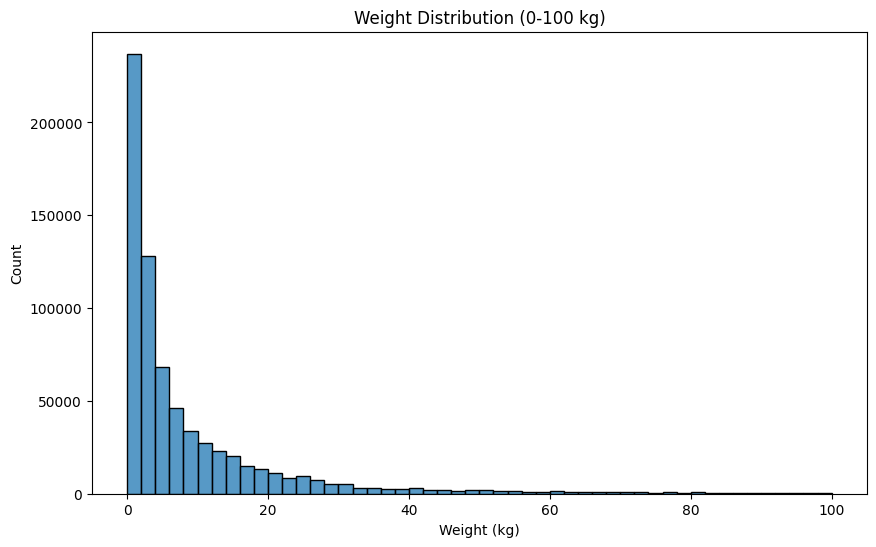

In [92]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['weight'] <= 100], x='weight', bins=50)
plt.title('Weight Distribution (0-100 kg)')
plt.xlabel('Weight (kg)')
plt.ylabel('Count')
plt.show()

### Shipment type analysis

The elements of shipment type don't have any formatting problems

In [93]:
shipment_types = df['shipment_type'].value_counts()
print("\nUnique shipment types and counts:")
print(shipment_types)


Unique shipment types and counts:
shipment_type
Parcel      647069
Document     64109
Name: count, dtype: int64


### Insurance type analysis

The elements of insurance type don't have any formattign problems

In [94]:
insurance_types = df['insurance_type'].value_counts()
print("\nUnique insurance types and counts:")
print(insurance_types)


Unique insurance types and counts:
insurance_type
No_Insurance         659729
Premium_Insurance     34486
Basic_Insurance       16963
Name: count, dtype: int64


### Booking state analysis

The elements are as described in the documentation

In [95]:
booking_states = df['booking_state'].value_counts()
print("\nUnique insurance types and counts:")
print(booking_states)


Unique insurance types and counts:
booking_state
12    682608
19     28681
16       113
10        18
14        17
13         9
7          5
11         4
15         2
18         1
Name: count, dtype: int64


## Customer Analysis

### lms plus analysis

In [96]:
analyze_missing_values(df, 'lms_plus')

Total missing values: 280
Missing percentage: 0.04%


The values are consistent.

In [97]:
df['lms_plus'].unique()

array([ 0.,  1., nan])

### Is Master analysis

In [98]:
analyze_missing_values(df, 'is_master_customer')

Total missing values: 280
Missing percentage: 0.04%


The boolean consistency is respected.

In [99]:
df['is_master_customer'].unique()

array([True, False, nan], dtype=object)

### Segmentation analysis

High number of null values across some features can be a common pattern

In [100]:
stats = df['segmentation_customer'].unique()
nulls = df['segmentation_customer'].isna().sum()

print("\nSegmentation Analysis:")
print(stats)
print(f"\nNull values: {nulls}")


Segmentation Analysis:
[ 0. nan  2.  6.  3.  5.  1.  4.]

Null values: 116856


### Main industry name analysis

A third of the industry are not present

In [101]:
analyze_missing_values(df, 'main_industry_name_customer')

Total missing values: 222510
Missing percentage: 31.28%


Here we verify the case correctness of the industry name, by counting the values as they are, then putting them to lower case and comparing them to see if we can spot differences. 
There aren't.

In [102]:
analyze_text_case_consistency(df, 'main_industry_name_customer')


Value counts - original: 368
Value counts - lowercase: 368


### Sector name analysis

The same number of values as for the industry name are missing, which makes sense since they are tied together.

Total missing values: 222510

In [103]:
analyze_missing_values(df, 'industry_sector_name_customer')

Total missing values: 222510
Missing percentage: 31.28%


Here we find no formatting issues.

In [104]:
analyze_text_case_consistency(df, 'industry_sector_name_customer')


Value counts - original: 19
Value counts - lowercase: 19


## Geographic analysis

### Delivery postal code analysis

A much lower percentage of missing values across the dataset.

In [105]:
analyze_missing_values(df, 'postal_code_delivery')

Total missing values: 16080
Missing percentage: 2.26%


There are case inconsistencies among postal codes:<br>
Postal codes with letters - original count: 13433<br>
Postal codes with letters - lowercase count: 13402

In [106]:
analyze_postal_code(df, 'postal_code_delivery')

Postal codes with letters - original count: 13433
Postal codes with letters - lowercase count: 13402

Case inconsistencies found:

Variants for 'ch65 3en':
['CH65 3EN' 'ch65 3en']

Variants for 'n9y 2e5':
['n9y 2e5' 'N9Y 2E5']

Variants for 'ng156dw':
['NG156DW' 'ng156dw']

Variants for 'j2s 8l2':
['J2S 8L2' 'j2s 8l2']

Variants for 'n2r 1h8':
['N2R 1H8' 'n2r 1h8']


This way we handle the inconsistencies.

In [107]:
df['postal_code_delivery'] = df['postal_code_delivery'].apply(standardize_postal_code)

### Delivery city analysis

A low numer of missing values are present in the delivery city: 281.

In [108]:
analyze_missing_values(df, 'city_delivery')

Total missing values: 281
Missing percentage: 0.04%


Lots of cities with inconsistencies in the case formatting:<br>
City counts - original: 74294<br>
City counts - lowercase: 62859

In [109]:
analyze_text_case_consistency(df, 'city_delivery')


Value counts - original: 74294
Value counts - lowercase: 62859

Case inconsistencies found:

Variants for 'hamburg':
['Hamburg' 'HAMBURG' 'hamburg' 'HAmburg' 'hAMBURG']

Variants for 'berlin':
['Berlin' 'BERLIN' 'berlin' 'bERLIN']

Variants for 'münchen':
['München' 'MÜNCHEN' 'münchen']

Variants for 'köln':
['Köln' 'köln' 'KÖLN' 'kÖLN']

Variants for 'bremen':
['Bremen' 'BREMEN' 'bremen']


In [110]:
# We standardize the city format
df['city_delivery'] = df['city_delivery'].str.lower().str.title()

###  Delivery country name analysis

Percetange wise, we still have a low amount of missing values, but it's highger than in the pickup city column: 30872 vs 281.

In [111]:
analyze_missing_values(df, 'name_country_delivery')

Total missing values: 30872
Missing percentage: 4.34%


No inconsistencies.

In [112]:
analyze_text_case_consistency(df, 'name_country_delivery')



Value counts - original: 176
Value counts - lowercase: 176


In [113]:
print("\nFirst 5 name_pickup values:")
print(df['name_country_delivery'].head())


First 5 name_pickup values:
0    Germany
1    Germany
2    Germany
3    Germany
4    Germany
Name: name_country_delivery, dtype: object


### Iso country code delivery analysis

The missing values are round the same as in the delivery country column.

In [114]:
analyze_missing_values(df, 'iso_country_code_delivery')

Total missing values: 30894
Missing percentage: 4.34%


In [115]:
df["iso_country_code_delivery"].head()

0    DE
1    DE
2    DE
3    DE
4    DE
Name: iso_country_code_delivery, dtype: object

In [116]:
df['iso_country_code_delivery'].unique()

array(['DE', 'CN', 'CZ', nan, 'NL', 'MX', 'PL', 'CO', 'GB', 'MY', 'MG',
       'SG', 'AE', 'IT', 'SE', 'PT', 'AT', 'CH', 'LT', 'JO', 'LU', 'EC',
       'BE', 'OM', 'AU', 'IN', 'HK', 'KR', 'NG', 'GH', 'RO', 'HR', 'ID',
       'ES', 'GR', 'JP', 'SI', 'FR', 'LV', 'DK', 'NZ', 'KZ', 'PA', 'HU',
       'IL', 'PK', 'LK', 'CA', 'CI', 'IE', 'IC', 'MT', 'FI', 'SK', 'BG',
       'RS', 'AO', 'QA', 'CL', 'SA', 'EG', 'BR', 'BD', 'NO', 'DZ', 'PE',
       'BB', 'CY', 'AG', 'EE', 'MD', 'BH', 'HN', 'IS', 'BJ', 'DO', 'MA',
       'LB', 'AR', 'AL', 'BF', 'AM', 'AZ', 'BA', 'JM', 'PH', 'LC', 'MV',
       'BI', 'GN', 'GP', 'KW', 'KV', 'MU', 'GF', 'SC', 'MM', 'MR', 'KE',
       'SV', 'RE', 'MK', 'PY', 'MZ', 'IQ', 'CR', 'FJ', 'IM', 'BO', 'MO',
       'CV', 'GE', 'SN', 'LI', 'CM', 'ME', 'ET', 'KH', 'NI', 'PR', 'KG',
       'LY', 'GT', 'NC', 'HT', 'PF', 'BW', 'MW', 'MN', 'MQ', 'TG', 'AI',
       'BS', 'GI', 'MC', 'SL', 'FO', 'NP', 'CG', 'NE', 'ML', 'KY', 'SR',
       'DM', 'AW', 'SD', 'ER', 'GW', 'SM', 'BN', 'AF

We find no inconsistencies.

In [117]:
analyze_text_case_consistency(df, 'iso_country_code_delivery')


Value counts - original: 175
Value counts - lowercase: 175


### Delivery continent analysis

There is a minimal change in the number of missing values with respect to the iso country code: 30872 vs 30894.

In [118]:
analyze_missing_values(df, 'continent_delivery')

Total missing values: 30872
Missing percentage: 4.34%


The format is respected across the unique values.

In [119]:
print(df['continent_delivery'].unique())

['Europe' 'Asia' nan 'America' 'Africa' 'Australia']


### EU delivery analysis

The same number of missing values an in the delivery continent.

In [120]:
analyze_missing_values(df, 'EU_delivery')

Total missing values: 30872
Missing percentage: 4.34%


It's boolean.

In [121]:
print(df['EU_delivery'].unique())

[ 1.  0. nan]


### Postal code pickup analysis

There a sizeable difference between missing values in the postal code pickup and postal code delivery: 1569 vs 16080.

In [122]:
analyze_missing_values(df, 'postal_code_pickup')

Total missing values: 1569
Missing percentage: 0.22%


In [123]:
analyze_postal_code(df, 'postal_code_pickup')

Postal codes with letters - original count: 1391
Postal codes with letters - lowercase count: 1389

Case inconsistencies found:

Variants for 'ct14 6at':
['ct14 6at' 'CT14 6AT']

Variants for 's60 1bx':
['s60 1bx' 'S60 1BX']


In [124]:
df['postal_code_pickup'] = df['postal_code_pickup'].apply(standardize_postal_code)

### City pickup analysis

The same number of missing values as in the city delivery.

In [125]:
analyze_missing_values(df, 'city_pickup')

Total missing values: 281
Missing percentage: 0.04%


In [126]:
analyze_text_case_consistency(df, 'city_pickup')


Value counts - original: 14288
Value counts - lowercase: 12816

Case inconsistencies found:

Variants for 'hamburg':
['Hamburg' 'HAMBURG' 'hamburg' 'HAmburg']

Variants for 'kiel':
['Kiel' 'KIEL']

Variants for 'berlin':
['Berlin' 'berlin' 'BERLIN' 'bERLIN']

Variants for 'bremen':
['Bremen' 'BREMEN' 'bremen']

Variants for 'bochum':
['Bochum' 'BOCHUM' 'bochum']


In [127]:
df['city_pickup'] = df['city_pickup'].str.lower().str.title()

### Domain name analysis

For the domain_name_delivery, we have almost the same number of missing values and in the delivery_city.

In [128]:
analyze_missing_values(df, 'domain_name_delivery')

Total missing values: 280
Missing percentage: 0.04%


The nomain name has an established format which is respected.

In [129]:
print(df['domain_name_delivery'].unique())

['DE' nan 'ES' 'FR' 'CH' 'BE' 'AT' 'NL']


## Service analysis

### Name Service Analysis

Negligent number of missing values.

In [130]:
analyze_missing_values(df, 'name_service')

Total missing values: 280
Missing percentage: 0.04%


In [131]:
analyze_text_case_consistency(df, 'name_service')


Value counts - original: 333
Value counts - lowercase: 328

Case inconsistencies found:

Variants for 'normal parcel international':
['Normal Parcel International' 'Normal Parcel international']

Variants for 'express national':
['Express National' 'Express national']

Variants for 'international economy':
['international economy' 'International Economy']

Variants for 'express 12:00 national':
['Express 12:00 National' 'Express 12:00 national']

Variants for 'express 12:00 import':
['Express 12:00 Import' 'EXPRESS 12:00 Import']


In [132]:
df['name_service'] = df['name_service'].str.lower().str.title()

### Service Type analysis

Also a negligent amount of missing values.

In [133]:
analyze_missing_values(df, 'service_type')

Total missing values: 280
Missing percentage: 0.04%


The format is stardard across all entries.

In [134]:
df['service_type'].unique()

array(['Standard', 'Import', 'Express', 'Special', 'Sameday', nan,
       'Third_Country'], dtype=object)

### Transport type analysis

The same number of missing values as service type, reasonable as they are part of the same dimension.

In [135]:
analyze_missing_values(df, 'transport_type')

Total missing values: 280
Missing percentage: 0.04%


The format is standard across entries.

In [136]:
df['transport_type'].unique()

array(['Standard', 'Express', 'Special', 'Standard_Palette',
       'Express_Palette', 'Sameday', nan], dtype=object)

### Name Carrier analysis

The same logic applies to the name of the carrier as with the above columns.

In [137]:
analyze_missing_values(df, 'name_carrier')

Total missing values: 280
Missing percentage: 0.04%


The format is consistent across all the instances.

In [138]:
df['name_carrier'].unique()

array(['UPS', 'TNT', 'FedEx', 'Logistik Helden KTG GmbH', 'DSV Road',
       'DPD', 'DHL', 'DHL S', 'GLS', 'Aramex', 'Der Kurier', 'Marway',
       nan, 'Delta-Stallion Internationale Transport GmbH',
       'Logistream GmbH', 'FME Frachtmanagement Europa GmbH',
       'Schwerdtfeger Transport', 'High Quality Transport Solution',
       'SamedayLogisitcs', 'Schenker', 'DSV', 'Correos', 'Transgesa',
       'Cargo Partner', 'Chronopost', 'DHL-Freight', 'Special',
       'Belsped AG', 'Sonstige',
       'Kintetsu World Express (Switzerland) Ltd.', 'Rhenus Logistics AG',
       'Z+L Zoll und Logistik GmbH', 'Bpost', 'Post AT',
       'Raben BEXity GmbH', 'Ontime Logistics Speditions GmbH',
       '3LOG premium logistics GmbH', 'SkyNet',
       'bgm express logistik GmbH', 'Global Express Austria GmbH',
       'Rhenus Logistics Austria GmbH', 'VELOX Express Gmbh', 'M3',
       'VT Verzollungen & Transporte GmbH', 'RBTC – Logistics B.V.',
       'ACS Time Critical Services GmbH', 'inline Kur

## Data quality summary

In this section we will analyze the missing values dataset wide.

In [139]:
# We create a summary DataFrame of missing values
missing = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': df.isnull().sum(),
    'Total Rows': len(df),
})

# We calculate the percentage of missing values
missing['Missing Percentage'] = (missing['Missing Values'] / missing['Total Rows'] * 100).round(2)

# We sort by percentage of missing values in descending order
missing = missing.sort_values('Missing Percentage', ascending=False)
missing = missing.reset_index(drop=True)

# We display only the columns with missing values
print("Missing Values Summary:\n")
print(f"Total number of rows in dataset: {len(df):,}\n")
print("Columns with missing values:")
print(missing[missing['Missing Values'] > 0])

Missing Values Summary:

Total number of rows in dataset: 711,458

Columns with missing values:
                           Column  Missing Values  Total Rows  \
0                      exworks_id          683441      711458   
1     main_industry_name_customer          222510      711458   
2   industry_sector_name_customer          222510      711458   
3           quarter_delivery_date          161562      711458   
4         full_date_delivery_date          161562      711458   
5              year_delivery_date          161562      711458   
6             month_delivery_date          161562      711458   
7             final_carrier_price          140156      711458   
8           segmentation_customer          116856      711458   
9    full_date_real_delivery_date           53558      711458   
10        year_real_delivery_date           53558      711458   
11       month_real_delivery_date           53558      711458   
12     quarter_real_delivery_date           53558      7114

High-Impact Missing Values (>20%):
The most significant missing data occurs in the exworks_id field, with 96.06% of values missing. This is followed by industry-related information (main_industry_name_customer and industry_sector_name_customer) where 31.28% of records lack values. Delivery date information (including year, month, quarter, and full date) is missing for 22.71% of records.

Moderate-Impact Missing Values (5-20%):
Financial data shows notable gaps, with final_carrier_price missing in 19.70% of records and customer segmentation information absent in 16.42% of cases. Real delivery and pickup date information shows consistent patterns of missing data, ranging from 6.68% to 7.53%.

Low-Impact Missing Values (1-5%):
Geographic and logistics information shows more completeness, with delivery-related location data (EU status, country information, and continent) missing in 4.34% of records. The margin calculations are unavailable for 4.05% of entries, while postal code delivery information is missing for 2.26% of records.

Minimal-Impact Missing Values (<1%):
A large number of fields show very low missing value rates of 0.04%, including core business data like transport type, insurance type, service information, and customer details. Pickup location information shows slightly higher but still minimal missing rates of 0.22-0.33%.


## Final processing

### Drop non needed features

They won't be seen again since they were registered in the past, and this is not a time series problem.

In [140]:
date_columns_to_drop = [col for col in df.columns if 'full_date' in col or 'created_date' in col]

# Drop the columns
df = df.drop(columns=date_columns_to_drop)

In [141]:
df.columns

Index(['shipment_id', 'customer_price', 'expected_carrier_price',
       'final_carrier_price', 'weight', 'shipment_type', 'insurance_type',
       'customer_id', 'domain_name', 'booking_state', 'lms_plus', 'exworks_id',
       'margin', 'domain_name_customer', 'main_industry_name_customer',
       'industry_sector_name_customer', 'segmentation_customer',
       'sequence_number_customer', 'structure_number_customer',
       'is_master_customer', 'domain_name_delivery', 'postal_code_delivery',
       'city_delivery', 'name_country_delivery', 'iso_country_code_delivery',
       'continent_delivery', 'EU_delivery', 'domain_name_pickup',
       'postal_code_pickup', 'city_pickup', 'name_country_pickup',
       'iso_country_code_pickup', 'continent_pickup', 'EU_pickup',
       'name_service', 'service_type', 'transport_type', 'domain_name_service',
       'name_carrier', 'domain_name_carrier', 'year_pickup_date',
       'month_pickup_date', 'quarter_pickup_date', 'year_delivery_date',
    

### Save dataset

In this section we save the dataset.

In [142]:
output_file = '../../../00-Project/datasets/preprocessed_flattened_dataset.csv'

df.to_csv(output_file, index=False)